## XAI Related Imports (in Docker only)

In [1]:
import os
import copy
import torch
from tensorboardX import SummaryWriter
import time
import glob
import re
import h5py
import datetime
import argparse
import csv
import math
from pathlib import Path
import torch.distributed as dist
from pcdet.datasets import build_dataloader
from pcdet.models import build_network
from pcdet.utils import common_utils
from pcdet.config import cfg, cfg_from_list, cfg_from_yaml_file, log_config_to_file
from pcdet.datasets.kitti.kitti_bev_visualizer import KITTI_BEV
from pcdet.datasets.cadc.cadc_bev_visualizer import CADC_BEV
from pcdet.utils import box_utils
from eval_utils import eval_utils
from XAI_utils.bbox_utils import *
from XAI_utils.tp_fp import *
from XAI_utils.XQ_utils import *
from pcdet.models import load_data_to_gpu
from pcdet.datasets.kitti.kitti_dataset import KittiDataset
from pcdet.datasets.cadc.cadc_dataset import CadcDataset
from pcdet.datasets.kitti.kitti_object_eval_python.eval import d3_box_overlap

# XAI related imports
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from torchvision import models

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [2]:
from XAI import *

## 2D Explanations (in Docker only)

### Indicating Dataset, Model, Explanation Method, Model Checkpoint

In [3]:
'''________________________User Input Begin________________________'''
dataset_name = 'KittiDataset' # change to your dataset, follow naming convention in the config yaml files in PCDet
method = 'IG'                 # explanation method
attr_shown = 'positive'       # show positive or negative attributions

# IG specific parameters
mult_by_inputs = True         # whether to show attributions only at where some input exists
steps = 24                    # number of intermediate steps for IG

# config file for the full PointPillars model
cfg_file = 'cfgs/kitti_models/pointpillar_xai.yaml' 
# config file for the truncated PointPillars model: 2D backbone and SSD
explained_cfg_file = 'cfgs/kitti_models/pointpillar_2DBackbone_DetHead_xai.yaml' 


# model checkpoint, change to your checkpoint, make sure it's a well-trained model
ckpt = '../output/kitti_models/pointpillar/default/ckpt/pointpillar_7728.pth'

'''________________________User Input End________________________'''

# creating config objects for the PointPillars and the truncated PointPillars model
x_cfg = copy.deepcopy(cfg)
cfg_from_yaml_file(cfg_file, cfg)
cfg.TAG = Path(cfg_file).stem
cfg.EXP_GROUP_PATH = '/'.join(cfg_file.split('/')[1:-1])
cfg_from_yaml_file(explained_cfg_file, x_cfg)

{'ROOT_DIR': PosixPath('/root/pcdet'),
 'LOCAL_RANK': 0,
 'CLASS_NAMES': ['Car', 'Pedestrian', 'Cyclist'],
 'DATA_CONFIG': {'DATASET': 'KittiDataset',
  'DATA_PATH': '../data/kitti',
  'POINT_CLOUD_RANGE': [0, -39.68, -3, 69.12, 39.68, 1],
  'DATA_SPLIT': {'train': 'train', 'test': 'val'},
  'INFO_PATH': {'train': ['kitti_infos_train.pkl'],
   'test': ['kitti_infos_val.pkl']},
  'FOV_POINTS_ONLY': True,
  'DATA_AUGMENTOR': {'DISABLE_AUG_LIST': ['placeholder'],
   'AUG_CONFIG_LIST': [{'NAME': 'gt_sampling',
     'USE_ROAD_PLANE': True,
     'DB_INFO_PATH': ['kitti_dbinfos_train.pkl'],
     'PREPARE': {'filter_by_min_points': ['Car:5',
       'Pedestrian:5',
       'Cyclist:5'],
      'filter_by_difficulty': [-1]},
     'SAMPLE_GROUPS': ['Car:15', 'Pedestrian:15', 'Cyclist:15'],
     'NUM_POINT_FEATURES': 4,
     'DATABASE_WITH_FAKELIDAR': False,
     'REMOVE_EXTRA_WIDTH': [0.0, 0.0, 0.0],
     'LIMIT_WHOLE_SCENE': False},
    {'NAME': 'random_world_flip', 'ALONG_AXIS_LIST': ['x']},
    

In [4]:
# create output directories, not very useful, just to be compatible with PCDet's structures
output_dir = cfg.ROOT_DIR / 'output' / cfg.EXP_GROUP_PATH / cfg.TAG / 'default'
output_dir.mkdir(parents=True, exist_ok=True)
eval_output_dir = output_dir / 'eval'

eval_all = False
eval_tag = 'default'

if not eval_all:
    num_list = re.findall(r'\d+', ckpt) if ckpt is not None else []
    epoch_id = num_list[-1] if num_list.__len__() > 0 else 'no_number'
    eval_output_dir = eval_output_dir / ('epoch_%s' % epoch_id) / cfg.DATA_CONFIG.DATA_SPLIT['test']
else:
    eval_output_dir = eval_output_dir / 'eval_all_default'

if eval_tag is not None:
    eval_output_dir = eval_output_dir / eval_tag

eval_output_dir.mkdir(parents=True, exist_ok=True)

In [5]:
# create logger, not very useful, just to be compatible with PCDet's structures
log_file = eval_output_dir / ('log_eval_%s.txt' % datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
logger = common_utils.create_logger(log_file, rank=cfg.LOCAL_RANK)

# log to file
logger.info('**********************Start logging**********************')

2021-03-17 02:19:47,431   INFO  **********************Start logging**********************


In [21]:
# arguments for dataloader
class_name_list = cfg.CLASS_NAMES
batch_size = 1
workers = 4
dist_test = False

# visualization parameters, don't change unless you really need to modify the visualizations
high_rez = True
scaling_factor = 5.0
color_map = 'gist_yarg'
dpi_division_factor = 20.0
box_margin_list = [0.2, 0.5, 1, 1.5, 2, 3, 5]
box_margin = 0.5
overlay = 0.4
figure_size = (32, 24)

In [7]:
# data set prepration, use the validation set (called 'test_set' here)
test_set, test_loader, sampler = build_dataloader(
        dataset_cfg=cfg.DATA_CONFIG,
        class_names=cfg.CLASS_NAMES,
        batch_size=batch_size,
        dist=dist_test, workers=workers, logger=logger, training=False
    )

2021-03-17 02:19:49,886   INFO  Loading KITTI dataset
2021-03-17 02:19:50,016   INFO  Total samples for KITTI dataset: 3769


In [8]:
# build the models and the explainers

# the partial PointPillars model
model2D = build_network(model_cfg=x_cfg.MODEL, num_class=len(x_cfg.CLASS_NAMES), dataset=test_set)
model2D.load_params_from_file(filename=ckpt, logger=logger, to_cpu=dist_test)
model2D.cuda()
model2D.eval()

# the full PointPillars model
model = build_network(model_cfg=cfg.MODEL, num_class=len(cfg.CLASS_NAMES), dataset=test_set)
model.load_params_from_file(filename=ckpt, logger=logger, to_cpu=dist_test)
model.cuda()
model.eval()

2021-03-17 02:19:52,884   INFO  ==> Loading parameters from checkpoint ../output/kitti_models/pointpillar/default/ckpt/pointpillar_7728.pth to GPU
2021-03-17 02:19:52,970   INFO  ==> Done (loaded 121/121)
2021-03-17 02:19:53,008   INFO  ==> Loading parameters from checkpoint ../output/kitti_models/pointpillar/default/ckpt/pointpillar_7728.pth to GPU
2021-03-17 02:19:53,100   INFO  ==> Done (loaded 127/127)



 data type of num_filters in PillarVFE: <class 'list'>

 length of num_filters: 2

 num_filters[0]: 10

 num_filters[1]: 64


PointPillarXAI(
  (vfe): PillarVFEXAI(
    (pfn_layers): ModuleList(
      (0): PFNLayer(
        (linear): Linear(in_features=10, out_features=64, bias=False)
        (norm): BatchNorm1d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      )
    )
  )
  (backbone_3d): None
  (map_to_bev_module): PointPillarScatterXAI()
  (pfe): None
  (backbone_2d): BaseBEVBackboneXAI(
    (blocks): ModuleList(
      (0): Sequential(
        (0): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (2): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (3): ReLU()
        (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (5): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (6): ReLU()
        (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (8): Ba

In [9]:
# explainer 
explainer = None

# build the IG explainer
ig2D = IntegratedGradients(model2D, multiply_by_inputs=mult_by_inputs)

if method == "IG":
    explainer = ig2D

In [10]:
# initialize the visulizer, need to change if you are using a different dataset
bev_visualizer = KITTI_BEV(dataset=test_set, scale_to_pseudoimg=(not high_rez), class_name=class_name_list,
                          background='black',
                          result_path='output/kitti_models/pointpillar/default/eval/epoch_7728/val/default/result.pkl',
                          scale=scaling_factor, cmap=color_map, dpi_factor=dpi_division_factor,
                          margin_list=box_margin_list)
if dataset_name == "CadcDataset":
    bev_visualizer = CADC_BEV(dataset=test_set, scale_to_pseudoimg=(not high_rez), class_name=class_name_list,
                        background='black',
                        scale=scaling_factor, cmap=color_map, dpi_factor=dpi_division_factor, margin=box_margin)

self.margins: [0.2, 0.5, 1, 1.5, 2, 3, 5]


### Indicate the Specific Sample to be Explained and Get Explanations

In [11]:
'''________________________User Input Begin________________________'''
# since batch_size = 1, the 56th batch is exactly the 56th frame in the validation set
val_batch_index = 56
'''________________________User Input End________________________'''

'________________________User Input End________________________'

In [12]:
# run the forward pass once to generate outputs and intermediate representations
batch_dict = {}
for batch_num, batch_dictionary in enumerate(test_loader):
    if batch_num == val_batch_index:
        batch_dict = batch_dictionary
        break
dummy_tensor = 0  # necessary for the XAI operations
load_data_to_gpu(batch_dict)
anchors_scores = None
with torch.no_grad():
    anchors_scores = model(dummy_tensor, batch_dict)
pred_dicts = batch_dict['pred_dicts']
pred_boxes_i = pred_dicts[0]['pred_boxes'].cpu().numpy()
pred_labels_i = pred_dicts[0]['pred_labels'].cpu().numpy() - 1

In [13]:
# obtain the Pseudoimage
PseudoImage2D = batch_dict['spatial_features']

In [14]:
# run the visualizer to get BEV of the original lidar point cloud with predictions and gt boxes labelled
bev_visualizer.set_pred_box(pred_boxes_i, pred_labels_i)
pred_boxes_for_pts = bev_visualizer.pred_boxes_for_cnt
bev_fig, bev_fig_data = bev_visualizer.get_bev_image(val_batch_index)
pred_boxes_vertices = bev_visualizer.pred_poly
padded_pred_boxes_vertices = bev_visualizer.pred_poly_expand
gt_boxes_vertices = bev_visualizer.gt_poly
gt_boxes_loc = bev_visualizer.gt_loc
pred_boxes_loc = bev_visualizer.pred_loc


result_frame.keys(): dict_keys(['name', 'truncated', 'occluded', 'alpha', 'bbox', 'dimensions', 'location', 'rotation_y', 'score', 'boxes_lidar', 'frame_id'])

val sample_idx: 000134

number of gt boxes according to the get_label method of the dataset object: 15

Processing Sample: 000134
len(self.pred_poly_expand): 7


In [15]:
# need to horizontally flip the original bev image and rotate 90 degrees ccw to match location of explanations
bev_image_raw = np.flip(bev_fig_data, 0)
bev_image = np.rot90(bev_image_raw, k=1, axes=(0, 1))

In [16]:
# obtain anchor box ids corresponding to the predictions
anchor_select_i = batch_dict['anchor_selections'][0]

In [17]:
# print out the prediction labels and anchor indices
print("pred_box_id  anchor_box_id  pred_label")
for i in range(len(anchor_select_i)):
    print("{0: ^12}{1: ^14}{2: ^14}".format(i, anchor_select_i[i], class_name_list[pred_labels_i[i]]))

pred_box_id  anchor_box_id  pred_label
     0          172608         Car      
     1          199965      Pedestrian  
     2          196686         Car      
     3          189590      Pedestrian  
     4          188249       Cyclist    
     5          163671      Pedestrian  
     6          117166       Cyclist    
     7          124997       Cyclist    
     8          199935      Pedestrian  
     9          110555       Cyclist    
     10         209068       Cyclist    
     11         83473          Car      
     12         179174      Pedestrian  
     13         114341       Cyclist    
     14         111936         Car      
     15         91220       Pedestrian  
     16         120111      Pedestrian  
     17         137739      Pedestrian  
     18         232888       Cyclist    
     19         66623        Cyclist    
     20         133725      Pedestrian  
     21         184938         Car      
     22         115689      Pedestrian  
     23         11

In [18]:
'''________________________User Input Begin________________________'''
anchor_id = 188249         # select the anchor box you want to explain
class_id = 2               # dataset dependent, e.g., 2 means cyclist for KITTI
'''________________________User Input End________________________'''

# assign target and get attributions
target = (anchor_id, class_id)
attributions = explainer.attribute(PseudoImage2D, baselines=PseudoImage2D * 0, target=target,
                                   additional_forward_args=batch_dict, n_steps=steps,
                                   internal_batch_size=batch_dict['batch_size'])

In [19]:
# separating the positive and negative gradients

# transform the attributions to match lidar bev orientation
grad = np.transpose(attributions[0].squeeze().cpu().detach().numpy(), (1, 2, 0))
pos_grad = np.sum((grad > 0) * grad, axis=2)
neg_grad = np.sum(-1 * (grad < 0) * grad, axis=2)
pos_grad_copy = copy.deepcopy(pos_grad)
neg_grad_copy = copy.deepcopy(neg_grad)

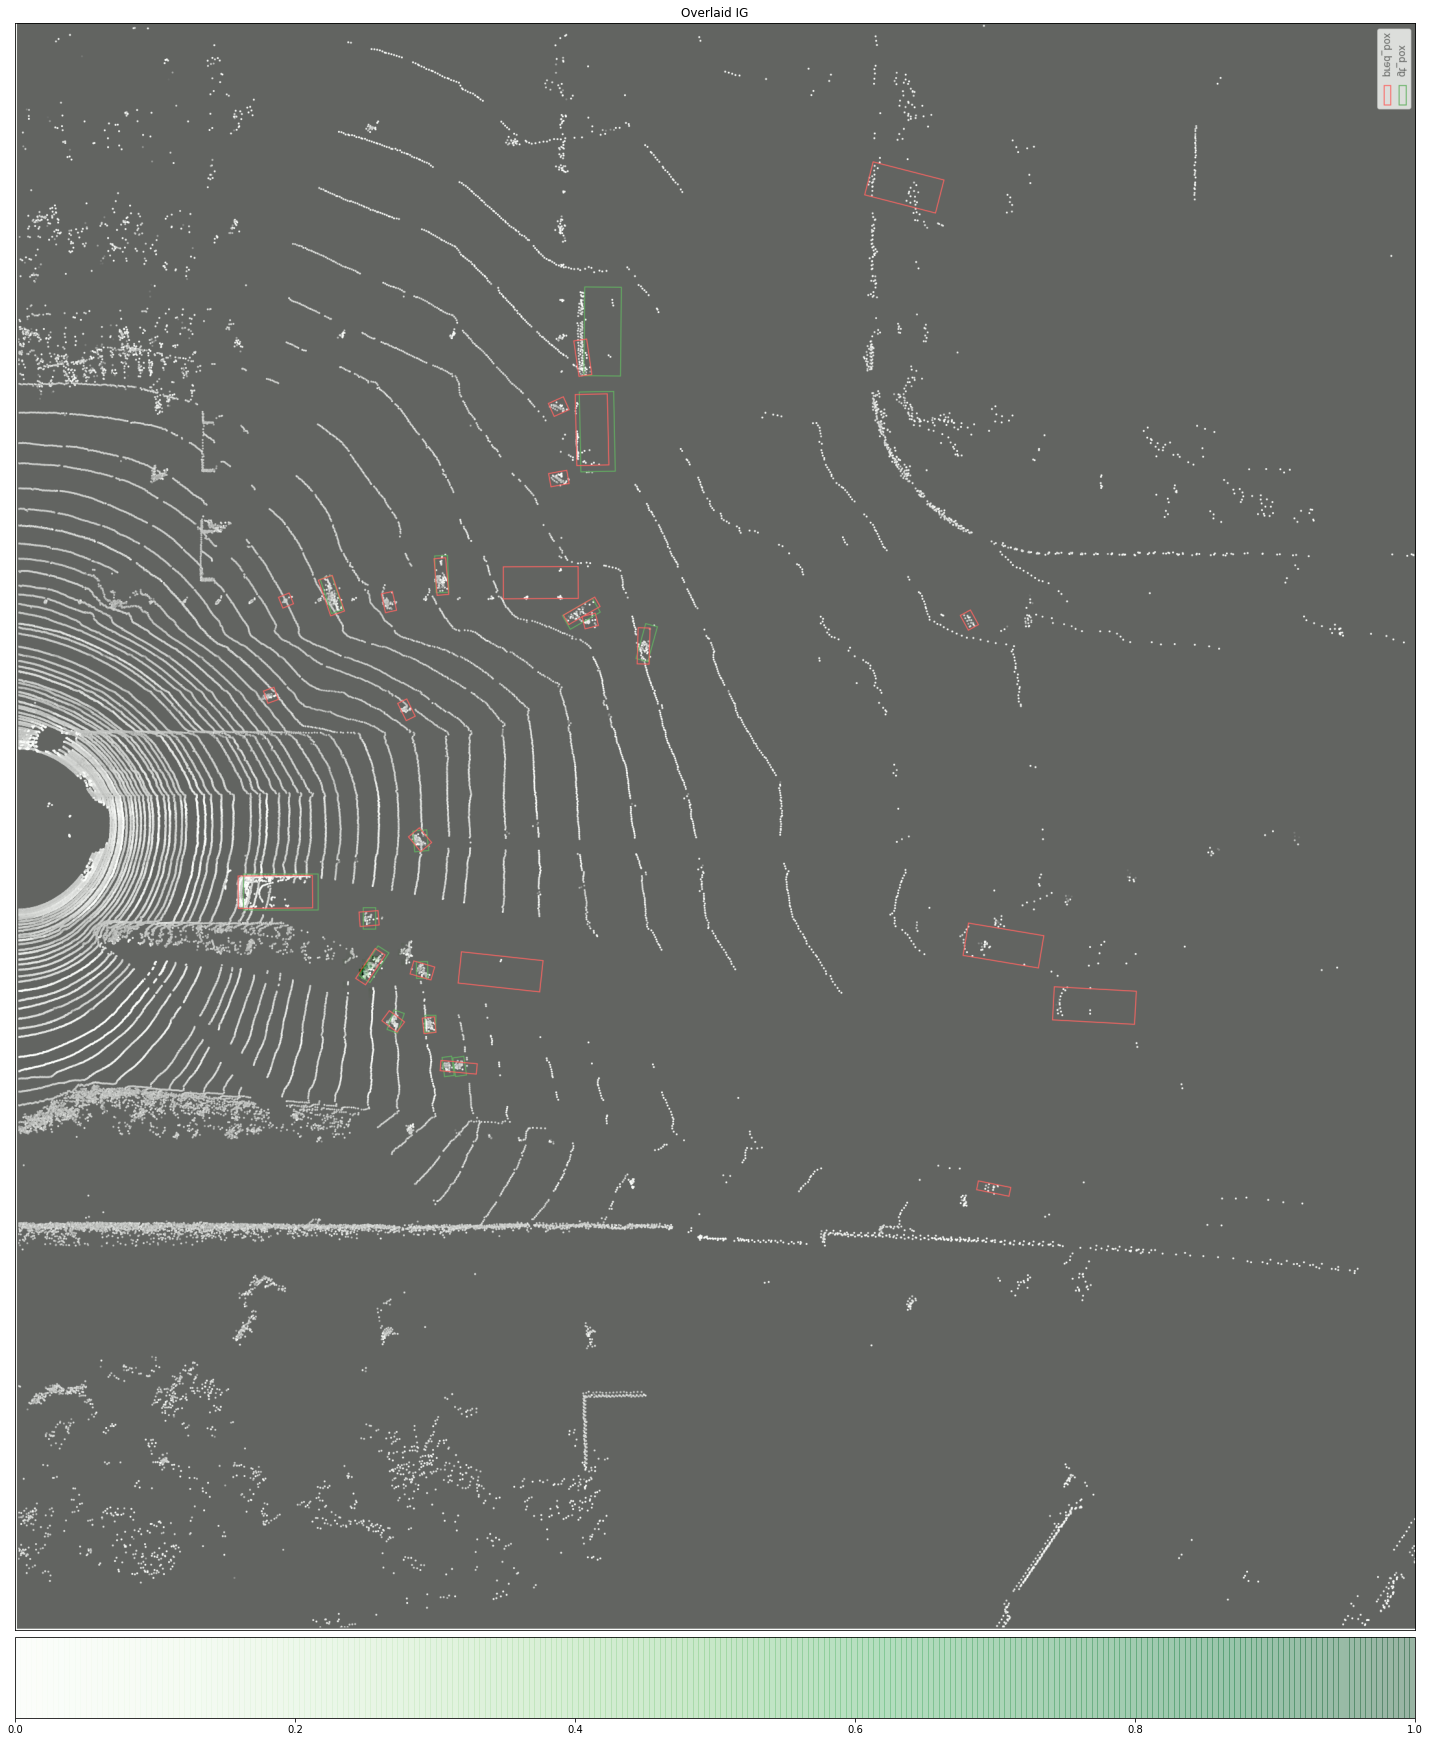

<AxesSubplot:title={'center':'Overlaid IG'}>

In [22]:
# generate visualization: pseudoimage attribution overlaid on top of lidar bev
grad_viz = viz.visualize_image_attr(grad, bev_image, method="blended_heat_map", sign=attr_shown, show_colorbar=True,
                                    title="Overlaid {}".format(method), alpha_overlay=overlay,
                                    fig_size=figure_size, upscale=high_rez)
grad_viz[1]

## LiDAR Frame and 2D Image Visualization (can run locally)

In [2]:
import pickle
import numpy as np
import pandas as pd
import open3d as o3d
from pathlib import Path

import matplotlib.pyplot as plt


import visualiser_hn as vis

import importlib



In [3]:
file_name = '../data/kitti/kitti_infos_trainval.pkl' #Change your own part
with open(file_name, 'rb') as f:
    infos = pickle.load(f)
    
print("Data length: ", len(infos))

Data length:  7481


In [4]:
infos[3]

{'point_cloud': {'num_features': 4, 'lidar_idx': '000009'},
 'image': {'image_idx': '000009',
  'image_shape': array([ 375, 1242], dtype=int32)},
 'calib': {'P2': array([[7.21537720e+02, 0.00000000e+00, 6.09559326e+02, 4.48572807e+01],
         [0.00000000e+00, 7.21537720e+02, 1.72854004e+02, 2.16379106e-01],
         [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 2.74588400e-03],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
  'R0_rect': array([[ 0.9999239 ,  0.00983776, -0.00744505,  0.        ],
         [-0.0098698 ,  0.9999421 , -0.00427846,  0.        ],
         [ 0.00740253,  0.00435161,  0.9999631 ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  1.        ]],
        dtype=float32),
  'Tr_velo_to_cam': array([[ 7.53374491e-03, -9.99971390e-01, -6.16602018e-04,
          -4.06976603e-03],
         [ 1.48024904e-02,  7.28073297e-04, -9.99890208e-01,
          -7.63161778e-02],
         [ 9.99862075e-01,  7.52379000e-03,  1.480755

In [5]:
root_split_path = Path('../data/kitti/training') #Change your own part

def get_lidar(idx):
    lidar_file = root_split_path / 'velodyne' / ('%s.bin' % idx)
    print(lidar_file)
    assert lidar_file.exists()
    return np.fromfile(str(lidar_file), dtype=np.float32).reshape(-1, 4)

from skimage import io

def get_image(idx):
    img_file = root_split_path / 'image_2' / ('%s.png' % idx)
    assert img_file.exists()
    return np.array(io.imread(img_file))


def search_sample(idx,infos):
    for i,info in enumerate(infos):
        if info['point_cloud']['lidar_idx'] == idx:
            return i
    print("no sample exist")
    print(idx)
    return None


In [6]:
def get_frame_id(batch_index, frame_id_file):
    index_mapping = pd.read_csv(frame_id_file)
    frame_indices = index_mapping['orig_frame_id']
    frame_id = frame_indices[batch_index]
    return str(frame_id).zfill(6)

In [7]:
val_batch_index = 56                # change to the frame you are interested in
frame_id_file = 'val_frame_idx.csv'  # change to your own

frame_id = get_frame_id(val_batch_index, frame_id_file)
print(frame_id)

000134


000134
../data/kitti/training/velodyne/000134.bin


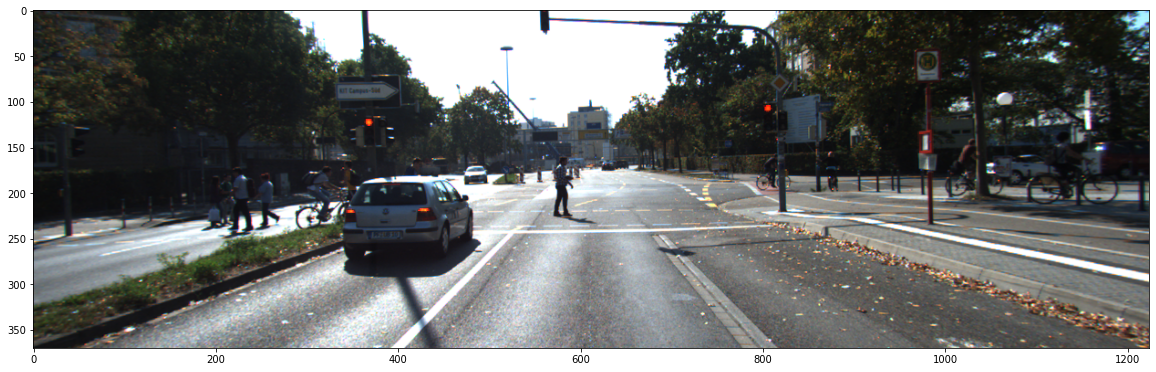

(15, 7)


In [8]:
sample_index = frame_id

info_index = search_sample(sample_index,infos)

info = infos[info_index]

lidar_idx = info['point_cloud']['lidar_idx']
print(lidar_idx)
lidar_points=get_lidar(lidar_idx)

image_idx = info['image']['image_idx']
image = get_image(image_idx)
figure = plt.figure(figsize=(20,10))
plt.imshow(image)
plt.show()


gt_boxes = info['annos']['gt_boxes_lidar']
print(gt_boxes.shape)


vis.vis_points_with_multi_boxes(gt_boxes,lidar_points[:,:3])